In [1]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import logging
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# Configure logging to show debug messages only from our project code
# Set root logger to WARNING to suppress debug from other libraries
logging.getLogger().setLevel(logging.DEBUG)

# ignore debug messages from other libraries
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# deterministic random seed for reproducibility
import random
random.seed(42)
np.random.seed(42) 


# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree
from src.dyadictreenode import DyadicTreeNode
from src.utils import *

from load_mnist import load_dataset

X shape: (1000, 784)
1000


In [2]:
logging.getLogger().setLevel(logging.WARNING)

# ========== NEW: Scikit-learn-like API Demo ==========

# Load fresh MNIST data for the demo
X_demo, original_shape_demo = load_dataset(flatten=True, num_points=100)

# Create a new CoverTree for clean demo
cover_tree_demo = CoverTree(X_demo, euclidean, leafsize=10)

# Create DyadicTree using NEW API (without fitting yet)
dyadic_sklearn = DyadicTree(
    cover_tree=cover_tree_demo,
    manifold_dims=0,      # Expected intrinsic dimension
    max_dim=X_demo.shape[-1],  # Maximum basis dimension  
    thresholds=0.0,       # Thresholds for basis construction
    precisions=1e-2,      # Precision parameters
    inverse=True          # Data in (n,d) format
)

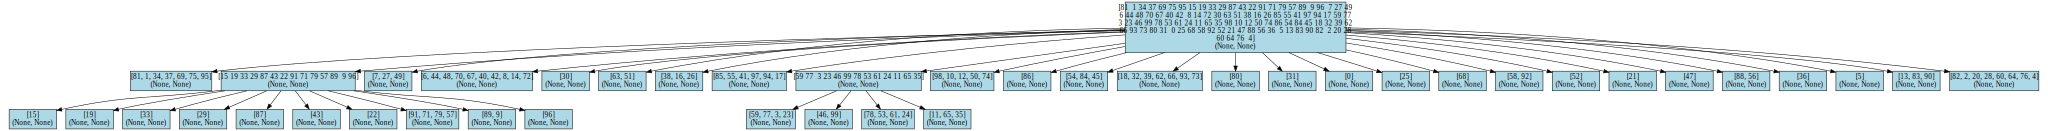

In [3]:
_ = dyadic_sklearn.plot_tree_graphviz()

In [4]:
# Prune nodes with fewer than 50 points
min_points = 10
print(f"\nPruning nodes with fewer than {min_points} points...")
dyadic_sklearn.prune_tree_min_point(min_points)

print("\nAfter pruning:")
print(f"Tree height: {dyadic_sklearn.height}")
print("Tree structure:")
dyadic_sklearn.traverse()

# Get leaf nodes after pruning
leafs_after = dyadic_sklearn.get_all_leafs()
print(f"\nNumber of leaf nodes after pruning: {len(leafs_after)}")
if leafs_after:
    point_counts_after = [len(leaf.idxs) for leaf in leafs_after]
    print(f"Point counts in leaves: min={min(point_counts_after)}, max={max(point_counts_after)}, mean={np.mean(point_counts_after):.1f}")
else:
    print("No leaf nodes remaining!")


Pruning nodes with fewer than 10 points...

After pruning:
Tree height: 2
Tree structure:
- [81  1 34 37 69 75 95 15 19 33 29 87 43 22 91 71 79 57 89  9 96  7 27 49
  6 44 48 70 67 40 42  8 14 72 30 63 51 38 16 26 85 55 41 97 94 17 59 77
  3 23 46 99 78 53 61 24 11 65 35 98 10 12 50 74 86 54 84 45 18 32 39 62
 66 93 73 80 31  0 25 68 58 92 52 21 47 88 56 36  5 13 83 90 82  2 20 28
 60 64 76  4]
-- [15 19 33 29 87 43 22 91 71 79 57 89  9 96]
-- [6, 44, 48, 70, 67, 40, 42, 8, 14, 72]
-- [59 77  3 23 46 99 78 53 61 24 11 65 35]

Number of leaf nodes after pruning: 3
Point counts in leaves: min=10, max=14, mean=12.3


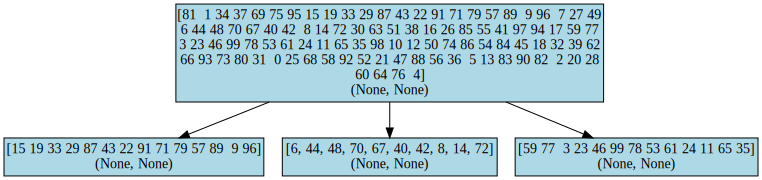

In [5]:
_ = dyadic_sklearn.plot_tree_graphviz()

In [6]:
dyadic_sklearn.fit(X_demo)

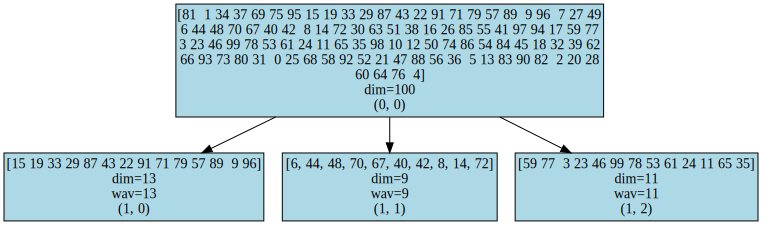

In [7]:
# plot the tree after fit basis
_ = dyadic_sklearn.plot_tree_graphviz(show_basis_dim=True)

In [10]:
logging.getLogger().setLevel(logging.INFO)
feat, leafjk = dyadic_sklearn.fgwt(X_demo)
logging.getLogger().setLevel(logging.DEBUG)
X_reconstructed = dyadic_sklearn.igwt(feat, leafjk, shape=X_demo.shape)

DEBUG:root:Starting inverse GMRA wavelet transform for 100 data points
DEBUG:root:Reconstruction target shape: (100, 784)
DEBUG:root:Reconstructing point 1/100
DEBUG:root:Point 0: starting from leaf (j=1, k=1), 2 coefficient levels
DEBUG:root:Point 0: leaf reconstruction, Qjx shape: (784, 1)
DEBUG:root:Point 0: root level reconstruction, final Qjx shape: (784, 1)
DEBUG:root:Point 0: reconstruction norm: 6.986617
DEBUG:root:***
DEBUG:root:Point 1: starting from leaf (j=1, k=0), 2 coefficient levels
DEBUG:root:Point 1: leaf reconstruction, Qjx shape: (784, 1)
DEBUG:root:Point 1: root level reconstruction, final Qjx shape: (784, 1)
DEBUG:root:***
DEBUG:root:Point 2: starting from leaf (j=1, k=0), 2 coefficient levels
DEBUG:root:Point 2: leaf reconstruction, Qjx shape: (784, 1)
DEBUG:root:Point 2: root level reconstruction, final Qjx shape: (784, 1)
DEBUG:root:***
DEBUG:root:Point 3: starting from leaf (j=1, k=2), 2 coefficient levels
DEBUG:root:Point 3: leaf reconstruction, Qjx shape: (78

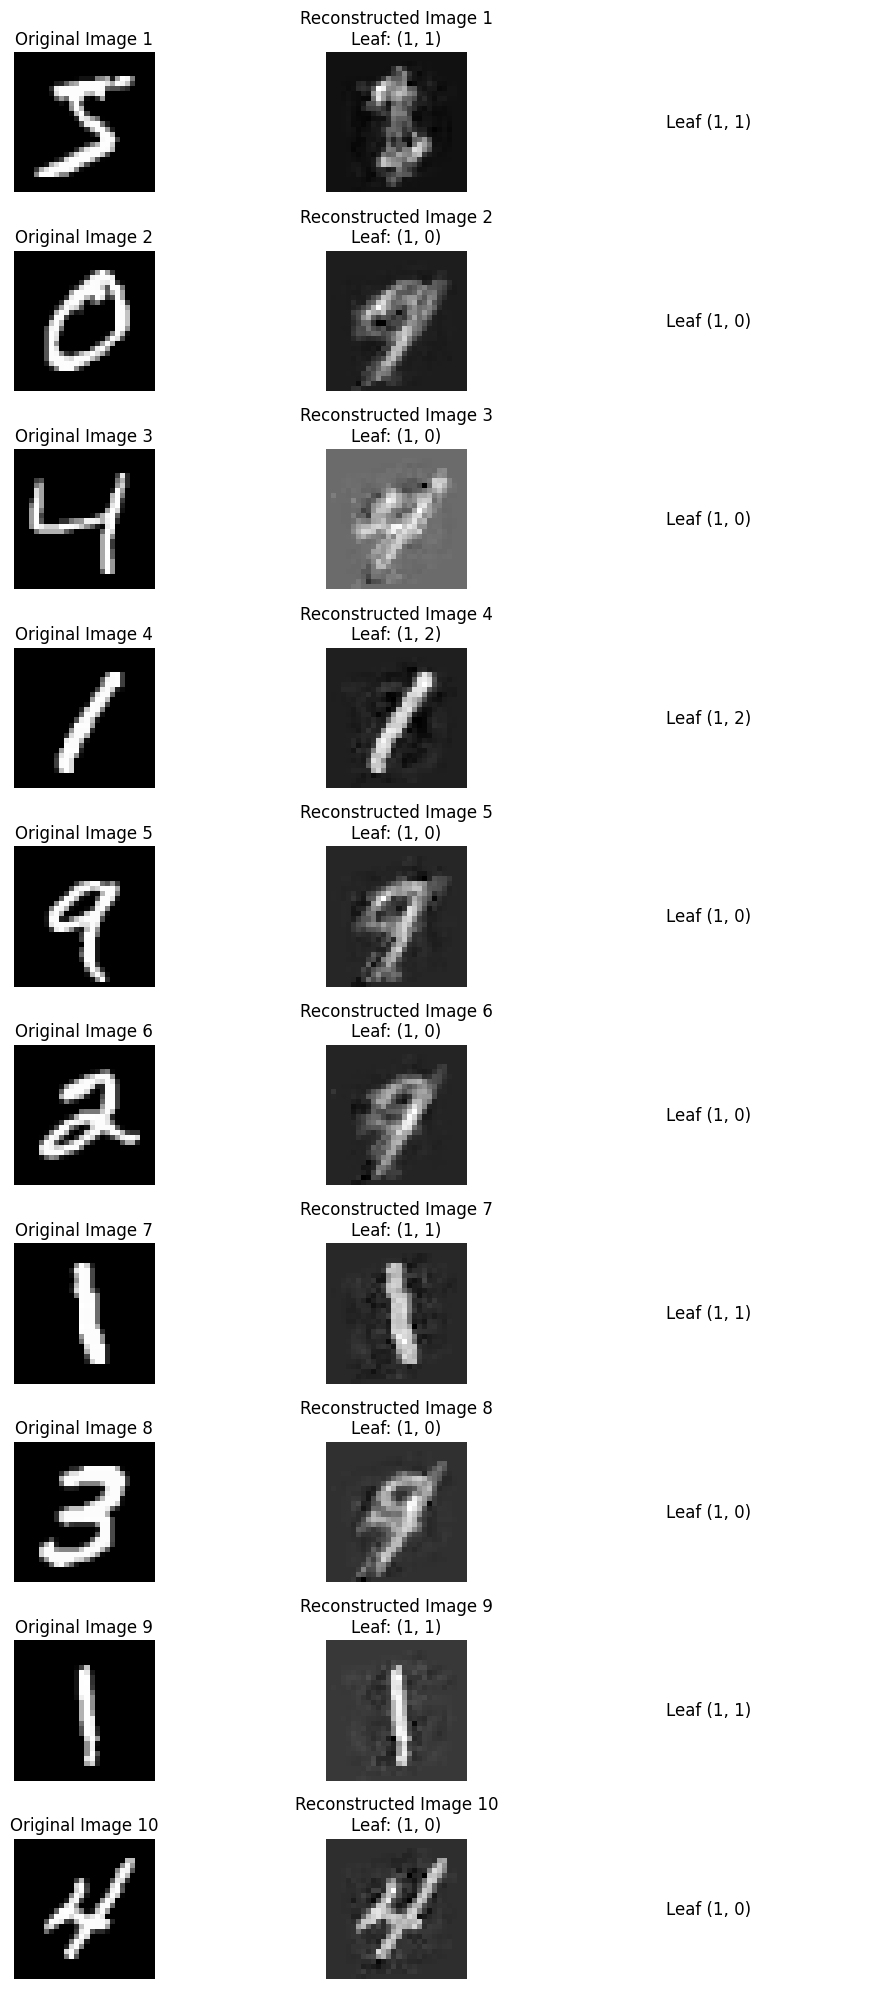

In [11]:
# visualize 10 original and reconstructed images
# and note the leaf used for each reconstruction (leaf jk)
# using graphviz

num_images = 10
fig, axes = plt.subplots(num_images, 3, figsize=(10, 2 * num_images))
for i in range(num_images):
    axes[i, 0].imshow(X_demo[i].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[i, 1].set_title(f"Reconstructed Image {i+1}\nLeaf: {leafjk[i]}")
    axes[i, 1].axis('off')

    axes[i, 2].text(0.5, 0.5, f"Leaf {leafjk[i]}", fontsize=12, ha='center', va='center')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

